In [2]:
import importlib
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from lightgbm import LGBMClassifier
from matplotlib import style
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

import model_evaluation

# 0. Preparation

In [3]:
# Load selected features
with open('../data/feature/feature_selection.pkl', 'rb') as f:
    feature_col = pickle.load(f)
    
# Form training set
file_train = pd.read_csv('../resources/File_train.csv')
df_train = pd.DataFrame()
for file in file_train['file']:
    df_train = df_train.append(pd.read_csv(f'../data/feature/{file}.csv'), ignore_index=True)

# Form testing set
file_test = pd.read_csv('../resources/File_test.csv')
df_test = pd.DataFrame()
for file in file_test['file']:
    df_test = df_test.append(pd.read_csv(f'../data/feature/{file}.csv'), ignore_index=True)

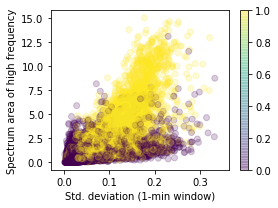

In [28]:
plt.figure(figsize=(4,3))
plt.scatter(df_train['std_1min'], df_train['area_hf'], c=df_train['apn'], cmap='viridis', alpha=0.2)
plt.colorbar()
plt.xlabel('Std. deviation (1-min window)')
plt.ylabel('Spectrum area of high frequency')
plt.tight_layout()
plt.savefig('../archive/std_hf.png', dpi=600)

In [8]:
# Test for selected features & all features
mdl=LogisticRegression(max_iter=1e4)
minute_auc, group_f1_macro, group_auc_macro, res_detail = model_evaluation.model_evaluation_CV(mdl, df_train, file_train, feature_col)
print(f'*** Selected features ***')
print(f'Minute_wise AUC: {minute_auc:.3f}, Group-wise AUC: {group_auc_macro:.3f}, Group-wise F1: {group_f1_macro}')

mdl=LogisticRegression(max_iter=1e4)
minute_auc, group_f1_macro, group_auc_macro, res_detail = model_evaluation.model_evaluation_CV(
    mdl, df_train, file_train, df_train.drop(['apn', 'file', 'group'], axis=1).columns)
print(f'*** All features ***')
print(f'Minute_wise AUC: {minute_auc:.3f}, Group-wise AUC: {group_auc_macro:.3f}, Group-wise F1: {group_f1_macro}')

*** Selected features ***
Minute_wise AUC: 0.885, Group-wise AUC: 0.951, Group-wise F1: 0.5211425973607386
*** All features ***
Minute_wise AUC: 0.885, Group-wise AUC: 0.950, Group-wise F1: 0.5203431545126286


# 1. Logistic Regression

In [14]:
# Hyperparameter tuning
# Optimal C: 0.05
# Minute_wise AUC: 0.888, Group-wise AUC: 0.951, Group-wise F1: 0.526
for C in [0.01, 0.05, 0.1, 0.5, 1, 5, 10]:
    mdl=LogisticRegression(C=C, max_iter=1e4)
    minute_auc, group_f1_macro, group_auc_macro, res_detail = model_evaluation.model_evaluation_CV(
        mdl, df_train, file_train, feature_col)
    print(f'*** C = {C:.2f} ***')
    print(f'Minute_wise AUC: {minute_auc:.3f}, Group-wise AUC: {group_auc_macro:.3f}, Group-wise F1: {group_f1_macro:.3f}')

*** C = 0.01 ***
Minute_wise AUC: 0.887, Group-wise AUC: 0.945, Group-wise F1: 0.521
*** C = 0.05 ***
Minute_wise AUC: 0.888, Group-wise AUC: 0.953, Group-wise F1: 0.524
*** C = 0.10 ***
Minute_wise AUC: 0.888, Group-wise AUC: 0.951, Group-wise F1: 0.526
*** C = 0.50 ***
Minute_wise AUC: 0.886, Group-wise AUC: 0.951, Group-wise F1: 0.523
*** C = 1.00 ***
Minute_wise AUC: 0.885, Group-wise AUC: 0.951, Group-wise F1: 0.521
*** C = 5.00 ***
Minute_wise AUC: 0.881, Group-wise AUC: 0.924, Group-wise F1: 0.497
*** C = 10.00 ***
Minute_wise AUC: 0.879, Group-wise AUC: 0.923, Group-wise F1: 0.497


# 2. MLP

In [17]:
# Hyperparameter tuning
# Optimal structure: 32 x 6
# Minute_wise AUC: 0.899, Group-wise AUC: 0.957, Group-wise F1: 0.568
for layer_size in [(16, 16), (32, 32), (64, 64), 
                   (16, ) * 6, (32, ) * 6, (64, ) * 6, 
                   (16, ) * 10, (32, ) * 10, (64, ) * 10]:
    mdl = MLPClassifier(
        hidden_layer_sizes=layer_size, 
        max_iter=2000,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=123)
    minute_auc, group_f1_macro, group_auc_macro, res_detail = model_evaluation.model_evaluation_CV(
        mdl, df_train, file_train, feature_col)
    print(f'*** Layer size: {layer_size} ***')
    print(f'Minute_wise AUC: {minute_auc:.3f}, Group-wise AUC: {group_auc_macro:.3f}, Group-wise F1: {group_f1_macro:.3f}')

*** Layer size: (16, 16) ***
Minute_wise AUC: 0.891, Group-wise AUC: 0.925, Group-wise F1: 0.522
*** Layer size: (32, 32) ***
Minute_wise AUC: 0.898, Group-wise AUC: 0.948, Group-wise F1: 0.525
*** Layer size: (64, 64) ***
Minute_wise AUC: 0.898, Group-wise AUC: 0.938, Group-wise F1: 0.558
*** Layer size: (16, 16, 16, 16, 16, 16) ***
Minute_wise AUC: 0.891, Group-wise AUC: 0.941, Group-wise F1: 0.578
*** Layer size: (32, 32, 32, 32, 32, 32) ***
Minute_wise AUC: 0.899, Group-wise AUC: 0.957, Group-wise F1: 0.568
*** Layer size: (64, 64, 64, 64, 64, 64) ***
Minute_wise AUC: 0.892, Group-wise AUC: 0.937, Group-wise F1: 0.560
*** Layer size: (16, 16, 16, 16, 16, 16, 16, 16, 16, 16) ***
Minute_wise AUC: 0.890, Group-wise AUC: 0.945, Group-wise F1: 0.543
*** Layer size: (32, 32, 32, 32, 32, 32, 32, 32, 32, 32) ***
Minute_wise AUC: 0.881, Group-wise AUC: 0.953, Group-wise F1: 0.574
*** Layer size: (64, 64, 64, 64, 64, 64, 64, 64, 64, 64) ***
Minute_wise AUC: 0.884, Group-wise AUC: 0.957, Grou

# 3. Light GBM

In [ ]:
# Hyperparameter tuning
# Minute_wise AUC: 0.898, Group-wise AUC: 0.956, Group-wise F1: 0.728
para = {
    'num_leaves': [8, 16, 32],
    'max_depth': [-1, 8, 16],
    'n_estimators': [50, 100, 500],
}
res_df = pd.DataFrame()

keys, values = zip(*para.items())
for v in itertools.product(*values):
    experiment = dict(zip(keys, v))
    gbm = LGBMClassifier(
        boosting_type='gbdt', **experiment, 
        random_state=123, n_jobs=-1, silent=True)
    res = model_evaluation.model_evaluation_CV(
        gbm, df_train, file_train, feature_col)
    experiment.update({
        'minute_auc': res['minute_auc_mean'],
        'group_f1_macro': res['group_f1_best'],
        'group_auc_macro': res['group_auc'],
    })
    res_df = res_df.append(experiment, ignore_index=True)

In [11]:
res_df.sort_values('minute_auc', ascending=False)

,group_auc_macro,group_f1_macro,max_depth,minute_auc,n_estimators,num_leaves
20,0.955924,0.727513,-1.0,0.897987,500.0,32.0
26,0.955664,0.714495,16.0,0.897635,500.0,32.0
2,0.958203,0.714495,-1.0,0.897416,500.0,8.0
5,0.958203,0.714495,8.0,0.897416,500.0,8.0
8,0.958203,0.714495,16.0,0.897416,500.0,8.0
17,0.956836,0.714495,16.0,0.897007,500.0,16.0
11,0.956836,0.714495,-1.0,0.897007,500.0,16.0
14,0.955143,0.727513,8.0,0.896750,500.0,16.0
23,0.960417,0.714744,8.0,0.896625,500.0,32.0
25,0.955078,0.719442,16.0,0.896339,100.0,32.0


# 4. Comparison using cross-validation

In [ ]:
# Define and CV evaluate models with the optimal hyperparameters
logreg = LogisticRegression(C=0.05, max_iter=1e4)
mlp = MLPClassifier(
    hidden_layer_sizes=(32, ) * 6, 
    max_iter=2000, early_stopping=True, validation_fraction=0.1,
    random_state=123)
gbm = LGBMClassifier(
    boosting_type='gbdt', num_leaves=8, max_depth=8, 
    learning_rate=0.1, n_estimators=50, 
    random_state=123, n_jobs=-1, silent=True)

mdl_res = []
for idx, mdl in enumerate([logreg, mlp, gbm]):
    res = model_evaluation.model_evaluation_CV(mdl, df_train, file_train, feature_col, plot_roc=True)
    mdl_res.append(res)

with open('../archive/Model_Evaluation.pkl', 'wb') as f:
    pickle.dump(mdl_res, f)

In [91]:
for res, mdl_name in zip(mdl_res, ['logreg', 'mlp', 'gbm']):
    print(f'*** {mdl_name} result ***')
    print(f"Minute AUC: {res['minute_auc_mean']:.3f}, "
          f"Group AUC (A vs rest): {res['group_auc']:.3f}, "
          f"Group best F1: {res['group_f1_best']:.3f}")

*** logreg result ***
Minute AUC: 0.888, Group AUC (A vs rest): 0.953, Group best F1: 0.715
*** mlp result ***
Minute AUC: 0.899, Group AUC (A vs rest): 0.957, Group best F1: 0.727
*** gbm result ***
Minute AUC: 0.888, Group AUC (A vs rest): 0.957, Group best F1: 0.735


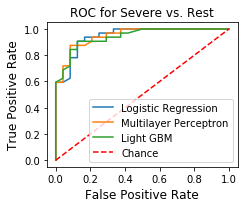

In [58]:
fig = plt.figure(figsize=(3.5, 3))
for idx, label in enumerate(['Logistic Regression', 'Multilayer Perceptron', 'Light GBM']):
    fpr = mdl_res[idx]['multiclass_auc']['fpr_A']
    tpr = mdl_res[idx]['multiclass_auc']['tpr_A']
#     plt.plot(fpr, tpr, label=f'{label} (auc={metrics.auc(fpr, tpr):.3f})')
    plt.plot(fpr, tpr, label=label)

plt.plot([0, 1], [0, 1], 'r--', label='Chance')
plt.xlabel('False Positive Rate', size=12)
plt.ylabel('True Positive Rate', size=12)
plt.title('ROC for Severe vs. Rest', size=12)
plt.legend()
plt.tight_layout()
plt.savefig('../archive/Model_Group_ROC.png', dpi=600)

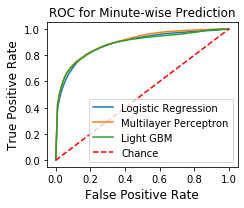

In [68]:
fig = plt.figure(figsize=(3.5, 3))
for idx, label in enumerate(['Logistic Regression', 'Multilayer Perceptron', 'Light GBM']):
    fpr = mdl_res[idx]['mean_fpr_minute']
    tpr = mdl_res[idx]['mean_tpr_minute']
#     plt.plot(fpr, tpr, label=f'{label} (auc={metrics.auc(fpr, tpr):.3f})')
    plt.plot(fpr, tpr, label=label)

plt.plot([0, 1], [0, 1], 'r--', label='Chance')
plt.xlabel('False Positive Rate', size=12)
plt.ylabel('True Positive Rate', size=12)
plt.title('ROC for Minute-wise Prediction', size=12)
plt.legend()
plt.tight_layout()
plt.savefig('../archive/Model_Minute_ROC.png', dpi=600)

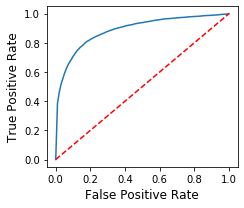

In [11]:
fig = plt.figure(figsize=(3.5, 3))
fpr = mdl_res[0]['mean_fpr_minute']
tpr = mdl_res[0]['mean_tpr_minute']
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], 'r--', label='Chance')
plt.xlabel('False Positive Rate', size=12)
plt.ylabel('True Positive Rate', size=12)
# plt.title('ROC for Minute-wise Prediction', size=12)
# plt.legend()
plt.tight_layout()
plt.savefig('../archive/Model_Minute_ROC_LogReg.png', dpi=600)

In [71]:
mdl_res[0]['thres_best']

0.61

# 5. Testing performance

In [10]:
# Model fitting using the whole training set
scaler = preprocessing.StandardScaler().fit(df_train[feature_col])
mdl=LogisticRegression(C=0.05, max_iter=1e4)
mdl.fit(scaler.transform(df_train[feature_col]), df_train['apn'])

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000.0,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
res = {'mdl': mdl, 'scaler': scaler}
with open('../resources/model_logreg.pkl', 'wb') as f:
    pickle.dump(res, f)

## Group-wise performance

              precision    recall  f1-score   support

           A       0.83      0.71      0.77         7
           B       0.67      0.67      0.67         3
           C       0.80      1.00      0.89         4

    accuracy                           0.79        14
   macro avg       0.77      0.79      0.77        14
weighted avg       0.79      0.79      0.78        14



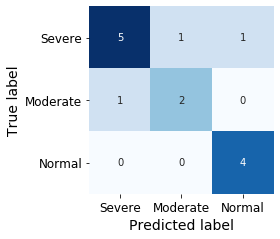

In [9]:
# Evaluation on testing set (Using optimal threshold for group-wise performance)
res = model_evaluation.model_evaluation_test(mdl, df_test, file_test, feature_col, scaler, thres=0.61)

# Plot confusion matrix
class_names = ['Severe', 'Moderate', 'Normal']
df_cm = pd.DataFrame(
    metrics.confusion_matrix(res['group_res']['true'], res['group_res']['pred']),
    index=class_names, columns=class_names, 
)
fig = plt.figure(figsize=(4, 3.5))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, cmap='Blues')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, fontsize=12)
plt.ylabel('True label', size=14)
plt.xlabel('Predicted label', size=14)
plt.tight_layout()
plt.ylim([3, 0])
# plt.savefig('../archive/Model_CM_group.png', dpi=300)

# Print classification report
print(metrics.classification_report(res['group_res']['true'], res['group_res']['pred']))

In [11]:
res['group_res'].drop(['neg', 'pos'], axis=1).replace({'A': 'Severe', 'B': 'Moderate', 'C': 'Normal'})

,true,pred
file,,
b09,Moderate,Moderate
a12,Severe,Severe
c07,Normal,Normal
a09,Severe,Moderate
c04,Normal,Normal
a13,Severe,Severe
a10,Moderate,Moderate
a06,Severe,Normal
b10,Moderate,Severe


## Minute-wise performance

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      3988
           1       0.83      0.71      0.76      2693

    accuracy                           0.82      6681
   macro avg       0.82      0.80      0.81      6681
weighted avg       0.82      0.82      0.82      6681



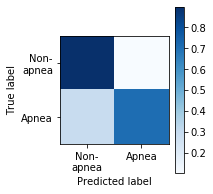

In [31]:
disp = metrics.plot_confusion_matrix(
    mdl, scaler.transform(df_test[feature_col]), df_test['apn'],
    display_labels=['Non-\napnea', 'Apnea'],
    cmap=plt.cm.Blues, include_values=False,
    normalize='true')
disp.figure_.set_size_inches((3, 3))
plt.tight_layout()
plt.savefig('../archive/Model_CM_minute.png', dpi=600)

print(metrics.classification_report(df_test['apn'], mdl.predict(scaler.transform(df_test[feature_col]))))

# 6. Comparison of testing performance

In [21]:
# Define and CV evaluate models with the optimal hyperparameters
logreg = LogisticRegression(C=0.05, max_iter=1e4)
mlp = MLPClassifier(
    hidden_layer_sizes=(32, ) * 6, 
    max_iter=2000, early_stopping=True, validation_fraction=0.1,
    random_state=123)
gbm = LGBMClassifier(
    boosting_type='gbdt', num_leaves=8, max_depth=8, 
    learning_rate=0.1, n_estimators=50, 
    random_state=123, n_jobs=-1, silent=True)

for mdl_name, mdl in zip(['Logistic Regression', 'MLP', 'Light GBM'], [logreg, mlp, gbm]):
    scaler = preprocessing.StandardScaler().fit(df_train[feature_col])
    mdl.fit(scaler.transform(df_train[feature_col]), df_train['apn'])
    print(f'*** {mdl_name} ***')
    print(metrics.classification_report(
        df_test['apn'],
        mdl.predict(scaler.transform(df_test[feature_col]))
         ))

*** Logistic Regression ***
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      3988
           1       0.83      0.71      0.76      2693

    accuracy                           0.82      6681
   macro avg       0.82      0.80      0.81      6681
weighted avg       0.82      0.82      0.82      6681

*** MLP ***
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      3988
           1       0.82      0.73      0.77      2693

    accuracy                           0.83      6681
   macro avg       0.82      0.81      0.82      6681
weighted avg       0.83      0.83      0.82      6681

*** Light GBM ***
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      3988
           1       0.80      0.71      0.75      2693

    accuracy                           0.81      6681
   macro avg       0.81      0.79      0.80      6681
weighted avg    

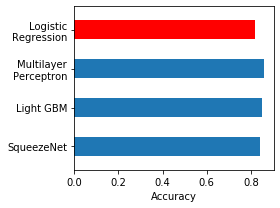

In [41]:
plt.figure(figsize=(4, 3))
plt.barh(np.arange(3, 0, -1), [0.86, 0.85, 0.84], height=0.5)
plt.barh([4], [0.82], height=0.5, color='r')
plt.yticks(
    [4, 3, 2, 1], 
    labels=[
        'Logistic\nRegression', 
        'Multilayer\nPerceptron',
        'Light GBM',
        'SqueezeNet'],
    )
plt.ylim([0.4, 4.6])
plt.xlabel('Accuracy')
plt.tight_layout()
plt.savefig('../archive/Model_Minute_Accuracy.png', dpi=600)

In [ ]:
# Backup block for sample visualization


file = 'a15'
with open('../HR_data/' + file + '.pkl', 'rb') as f:
    data = pickle.load(f)

b, a = signal.butter(3, 0.1)
t, hr = data['t'], data['hr']
idx_valid = (hr < 2) & (hr > 0.5)
hr, t = hr[idx_valid], t[idx_valid]
hr_smth = signal.filtfilt(b, a, hr)

res = np.transpose(seg_pred[file])
assert res.shape[0] == np.ceil(t[-1]) - 4

select_num = 3

plt.figure(figsize=(16, 12))
for case in range(4):
    if case == 0:
        val = [1, 0]
        label = 'False Negative'
    elif case == 1:
        val = [0, 1]
        label = 'False Positive'
    elif case == 2:
        val = [1, 1]
        label = 'True Positive'
    elif case == 3:
        val = [0, 0]
        label = 'True Negative'
        
    idx = np.where((res == val).all(axis=1))[0]
    idx_plot = np.random.choice(idx, select_num)
    
    plt.subplot(2, 2, case + 1)
    for idx in idx_plot:
        idx_t = (t > idx) & (t < idx + 5)
        plt.plot(t[idx_t] - idx, hr_smth[idx_t])
        
    plt.title(label)
    plt.xlabel('minute')
    plt.ylabel('HR')
    
plt.show()